
# CIFAR-10 Dataset

- CIFAR-10 is a well-known benchmark dataset in computer vision.  
- It contains 60,000 color images, each of size 32×32 pixels.  
- There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  
- The dataset is split into:
  - 50,000 training images
  - 10,000 test images

---

## Machine Learning Problem

- **Type**: Supervised image classification  
- **Task**: Learn to map image pixels to one of the 10 class labels.  
- **Goal**: Train a model that correctly predicts the class of unseen test images.  
- **Challenge**:  
  - Low resolution makes feature extraction harder.  
  - Some classes are visually similar (e.g., cat vs. dog, truck vs. automobile).  
- **Use case for feature extractors**: Models can be trained to extract meaningful features from the images, which can then be used for classification or transferred to other tasks.

## Pretrained Models

- In TensorFlow (via `tf.keras.applications`), pretrained models are trained on **ImageNet** (1.2M images, 1000 classes).  
- Popular choices include **MobileNetV2**, **EfficientNet**, **ResNet50**, and **InceptionV3**.  
- These models expect **larger input sizes** (usually 224×224 pixels or higher).  
  - To use them with CIFAR-10 (32×32), images must be **resized** to match the model’s expected input.  
- Each model comes with a dedicated `preprocess_input` function that prepares images (scaling and normalization) consistently with how the model was trained.  
- When used as **feature extractors**, we remove the final classification layer and keep the intermediate representation (embedding).  
  - These embeddings capture **general visual patterns** (edges, textures, object parts) learned from ImageNet.  
  - They can then be used to train a **new classifier** on CIFAR-10, or compared with **classical models** like Logistic Regression, SVM, kNN, or Random Forest.  

### Why use pretrained models?
- **Faster convergence**: We start from general-purpose vision features instead of random weights.  
- **Better accuracy**: Even though CIFAR-10 is small, ImageNet-pretrained features transfer well.  
- **Flexibility**: Embeddings can be reused for other datasets or tasks beyond CIFAR-10.  

---



 # Import the packages

In [1]:
# Standard library
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Magic command
%matplotlib inline


2025-09-06 09:50:32.818952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading the dataset

In [2]:
# Training set
X_train_valid: np.ndarray
y_train_valid: np.ndarray

# Test set
X_test: np.ndarray
y_test: np.ndarray

# Loading the dataset: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
(X_train_valid, y_train_valid), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
from sklearn.model_selection import train_test_split

# Validation set
X_valid: np.ndarray
y_valid: np.ndarray

# Create a valid set for models hyperparameters tuning
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.20, random_state=42)

print("Train set:")
print(f"  X_train: shape={X_train.shape}, dtype={X_train.dtype}")
print(f"  y_train: shape={y_train.shape}, dtype={y_train.dtype}")

print("\n Valid pset:")
print(f"  X_valid: shape={X_valid.shape}, dtype={X_valid.dtype}")
print(f"  y_valid: shape={y_valid.shape}, dtype={y_valid.dtype}")

print("\n Test set:")
print(f"  X_test:        shape={X_test.shape}, dtype={X_test.dtype}")
print(f"  y_test:        shape={y_test.shape}, dtype={y_test.dtype}")

Train set:
  X_train: shape=(40000, 32, 32, 3), dtype=uint8
  y_train: shape=(40000, 1), dtype=uint8

 Valid pset:
  X_valid: shape=(10000, 32, 32, 3), dtype=uint8
  y_valid: shape=(10000, 1), dtype=uint8

 Test set:
  X_test:        shape=(10000, 32, 32, 3), dtype=uint8
  y_test:        shape=(10000, 1), dtype=uint8


# Data preparation
* Get the map of labels
* Get the valid set

In [5]:
unique_labels: list[int] = list(np.unique(y_train_valid))
print(f'The list of unique label: {unique_labels}')

first_occurence_indices: list[int] = []

# Get the list of index for the first labels
for label in unique_labels:
    for idx in range(len(y_train_valid)):
        if y_train_valid[idx] == label:
           first_occurence_indices.append(idx)
           break
print(f'The first labels in increasing order:{first_occurence_indices}')

The list of unique label: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
The first labels in increasing order:[29, 4, 6, 9, 3, 27, 0, 7, 8, 1]


In [6]:
# https://www.cs.toronto.edu/~kriz/cifar.html
CLASS_NAMES: list[str] = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

label_to_class: dict[int, str] = dict(zip(unique_labels, CLASS_NAMES))

print("The map between label and class name:", label_to_class)

The map between label and class name: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


horse


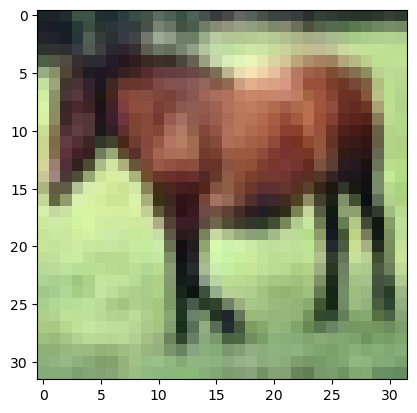

In [8]:
def print_class_plot_img(img_nbr:int)->None:
    print(label_to_class[y_train_valid[img_nbr].item()])
    plt.imshow(X_train_valid[img_nbr])

print_class_plot_img(img_nbr = 7)

**Note**: The images have a low resolution

# Feature engineering
* extract feature with pretrained models
* compare features extracted at different levels
* show top features by label

## Extact features from images
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://keras.io/api/applications/#extract-features-from-an-arbitrary-intermediate-layer-with-vgg19
- https://keras.io/api/applications/#usage-examples-for-image-classification-models


In [10]:
IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

### Feature extractor

In [ ]:
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model

# Load the model without the fully connected layer 
backbone: Model = MobileNetV2(
    weights="imagenet", 
    include_top=False, pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
backbone.trainable = False

# Build the feature extractor
feature_extractor: Model = tf.keras.Sequential()
feature_extractor.add(keras.layers.Input(shape=(32, 32, 3), dtype=tf.uint8))
feature_extractor.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, interpolation="bilinear"))
feature_extractor.add(keras.layers.Lambda(lambda x: preprocess_input(tf.cast(x, tf.float32))))
feature_extractor.add(backbone)

# Extract features
feat_train: np.ndarray = feature_extractor.predict(X_train, batch_size=256, verbose=0)  # (N_train, 1280)
feat_valid: np.ndarray = feature_extractor.predict(X_valid, batch_size=256, verbose=0)  # (N_valid, 1280)
feat_test: np.ndarray  = feature_extractor.predict(X_test,  batch_size=256, verbose=0)  # (N_test, 1280)

# Debug prints
print("Type of feat_train:", type(feat_train))
print("Shape of feat_train:", feat_train.shape)
print("feat_train dtype (expected: float32 by default):", feat_train.dtype)

print("Type of feat_valid:", type(feat_valid))
print("Shape of feat_valid:", feat_valid.shape)
print("feat_valid dtype (expected: float32 by default):", feat_valid.dtype)

print("Type of feat_test:", type(feat_test))
print("Shape of feat_test:", feat_test.shape)
print("feat_test dtype (expected: float32 by default):", feat_train.dtype)

Type of feat_train: <class 'numpy.ndarray'>
Shape of feat_train: (40000, 1280)
Type of feat_valid: <class 'numpy.ndarray'>
Shape of feat_valid: (10000, 1280)
Type of feat_test: <class 'numpy.ndarray'>
Shape of feat_test: (10000, 1280)


### Save features

In [12]:
from pathlib import Path

# Path to ../features relative to current working directory
features_dir: Path = (Path.cwd() / ".." / "features").resolve()
features_dir.mkdir(exist_ok=True)

In [ ]:
# Labels: flatten to 1-D
y_train_1d: np.ndarray = np.asarray(y_train).ravel().astype(np.int64)
y_valid_1d: np.ndarray = np.asarray(y_valid).ravel().astype(np.int64)
y_test_1d:  np.ndarray = np.asarray(y_test).ravel().astype(np.int64)

# Save the features and metadata as a single compressed NPZ
out_path = features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz"
np.savez_compressed(
    file = out_path,
    feat_train=feat_train,
    feat_valid=feat_valid,
    feat_test=feat_test,
    y_train=y_train_1d,
    y_valid=y_valid_1d,
    y_test=y_test_1d,
    backbone=np.array(["MobileNetV2"], dtype=object),
    img_size=np.array([IMG_SIZE], dtype=np.int32),
    dtype=np.array([str(feat_train.dtype)], dtype=object),
)
print("Saved to:", out_path)

Saved to: /mnt/c/Users/aelgu.adyx/Documents/unibe/m1_2_prj_cas_aml/features/mobilenetv2_160_features.npz


# Models training
* Dummy classify
* On the fly data augmentation
* Baseline model: logistic regression
* comparison with random forest
* hyperparameter tuning: GridsearchCV

## Load features

In [52]:
# Load features and labels from file
bundle = np.load(features_dir / f"mobilenetv2_{IMG_SIZE}_features.npz", allow_pickle=True)

# Take features (vectors) and labels
feat_train = bundle["feat_train"]
feat_valid = bundle["feat_valid"]
feat_test  = bundle["feat_test"]
y_train_1d = bundle["y_train"]
y_valid_1d = bundle["y_valid"]
y_test_1d  = bundle["y_test"]

# Print shape and dtype for check
print("feat_train:", feat_train.shape, feat_train.dtype)
print("feat_valid:", feat_valid.shape, feat_valid.dtype)
print("feat_test :", feat_test.shape,  feat_test.dtype)
print("y_train  :", y_train_1d.shape, y_train_1d.dtype)
print("y_valid  :", y_valid_1d.shape, y_valid_1d.dtype)
print("y_test   :", y_test_1d.shape,  y_test_1d.dtype)

feat_train: (40000, 1280) float32
feat_valid: (10000, 1280) float32
feat_test : (10000, 1280) float32
y_train  : (40000,) int64
y_valid  : (10000,) int64
y_test   : (10000,) int64


## Sklearn models

### Import sklearn packages

In [53]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### Helper function

In [54]:
def fit_and_report(clf, Xtr, ytr, Xte, yte, name="Model"):
    # clf.fit(Xtr, ytr)
    y_pred = clf.predict(Xte)
    print(f"[{name}] Accuracy:", accuracy_score(yte, y_pred))
    print(classification_report(yte, y_pred, digits=4))
    return None

### Dummy classifier

In [55]:
## TODO: add dummy classifier to have baseline to evaluate the learning of other models

### Logistic regression

In [56]:
# Logistic Regression (multiclass) + standardization
lr_clf: Pipeline = make_pipeline(
    StandardScaler(),  # scale features improves LR convergence
    LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",          # supports multinomial + n_jobs
        max_iter=500,
        n_jobs=-1,
        random_state=42,
    )
)

# Train on feature vectors (2D)
lr_clf.fit(feat_train, y_train_1d)

# Evaluate on validation features (2D)
fit_and_report(
    clf=lr_clf,
    Xtr=feat_train, ytr=y_train_1d,
    Xte=feat_valid, yte=y_valid_1d,
    name="Logistic Regression"
)

[Logistic Regression] Accuracy: 0.8272
              precision    recall  f1-score   support

           0     0.8325    0.8273    0.8299       973
           1     0.9079    0.9162    0.9120       979
           2     0.8024    0.7689    0.7853      1030
           3     0.7216    0.7019    0.7116      1023
           4     0.7639    0.8114    0.7869       933
           5     0.7740    0.7557    0.7647      1015
           6     0.8634    0.8695    0.8664       996
           7     0.8312    0.8370    0.8341       994
           8     0.8790    0.8859    0.8825      1017
           9     0.8907    0.9010    0.8958      1040

    accuracy                         0.8272     10000
   macro avg     0.8267    0.8275    0.8269     10000
weighted avg     0.8268    0.8272    0.8269     10000



### Random forest

In [57]:
# Random Forest classifier
rf_clf: RandomForestClassifier = RandomForestClassifier(
    n_estimators=300,      # number of trees
    max_depth=None,        # let trees expand fully (or set e.g. 20)
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",   # good default for classification
    bootstrap=True,
    n_jobs=-1,             # use all cores
    random_state=42,
)

# Train on feature vectors
rf_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
fit_and_report(clf=rf_clf, 
               Xtr=feat_train, ytr=y_train_1d, 
               Xte=feat_valid, yte=y_valid_1d, 
               name="Random forest")

[Random forest] Accuracy: 0.8184
              precision    recall  f1-score   support

           0     0.8172    0.8088    0.8130       973
           1     0.8943    0.9244    0.9091       979
           2     0.8513    0.7282    0.7849      1030
           3     0.6733    0.6911    0.6821      1023
           4     0.7405    0.8167    0.7768       933
           5     0.7765    0.7360    0.7557      1015
           6     0.8669    0.8896    0.8781       996
           7     0.8326    0.8058    0.8190       994
           8     0.8427    0.8958    0.8684      1017
           9     0.8940    0.8923    0.8932      1040

    accuracy                         0.8184     10000
   macro avg     0.8190    0.8189    0.8180     10000
weighted avg     0.8193    0.8184    0.8180     10000



### SVM

In [58]:
svm_clf: Pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, C=1.0, max_iter=5000, random_state=42)
)

svm_clf.fit(feat_train, y_train_1d)

# Evaluate on valid features
fit_and_report(clf=svm_clf, 
               Xtr=feat_train, ytr=y_train_1d, 
               Xte=feat_valid, yte=y_valid_1d, 
               name="SVM")

[SVM] Accuracy: 0.8429
              precision    recall  f1-score   support

           0     0.8422    0.8499    0.8460       973
           1     0.8805    0.9030    0.8916       979
           2     0.8545    0.7922    0.8222      1030
           3     0.7485    0.7185    0.7332      1023
           4     0.7973    0.8349    0.8157       933
           5     0.8032    0.7842    0.7936      1015
           6     0.8898    0.8996    0.8947       996
           7     0.8516    0.8773    0.8642       994
           8     0.8841    0.8850    0.8845      1017
           9     0.8717    0.8885    0.8800      1040

    accuracy                         0.8429     10000
   macro avg     0.8423    0.8433    0.8426     10000
weighted avg     0.8425    0.8429    0.8424     10000



## Tensorflow/keras models


### Import tensorflow/keras packages

In [59]:
import tensorflow as tf

keras = tf.keras
layers = keras.layers
regularizers = keras.regularizers
callbacks = keras.callbacks

# from tensorflow import keras
# from tensorflow.python.keras import layers, regularizers, callbacks

# from tensorflow import keras
# from tensorflow.keras import layers, regularizers, callbacks


### Dense model

In [ ]:
l2: float = 5e-4

# Fully connected classifier model (feedforward)
fc_clf: keras.Sequential = keras.Sequential([
    keras.Input(shape=(feat_train.shape[1],)),

    layers.Dropout(0.25),

    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),
    
    layers.Dense(256, use_bias=False, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.5),

    layers.Dense(10, activation="softmax"),
])

fc_clf.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

cbs: list = [
    callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
]

history: keras.callbacks.History = fc_clf.fit(
    feat_train, y_train_1d,
    validation_data=(feat_valid, y_valid_1d),  # use real validation set
    epochs=150,
    batch_size=256,
    callbacks=cbs,
    verbose=1,
)


print("Test accuracy:", fc_clf.evaluate(feat_test, y_test_1d, verbose=0)[1])

Epoch 1/150
157/157 [==============================] - 5s 22ms/step - loss: 2.1119 - accuracy: 0.4773 - val_loss: 1.1689 - val_accuracy: 0.8001 - lr: 0.0010
Epoch 2/150
157/157 [==============================] - 4s 22ms/step - loss: 1.3047 - accuracy: 0.7539 - val_loss: 0.9982 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 3/150
157/157 [==============================] - 3s 22ms/step - loss: 1.1437 - accuracy: 0.7919 - val_loss: 0.9137 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 4/150
157/157 [==============================] - 5s 32ms/step - loss: 1.0312 - accuracy: 0.8112 - val_loss: 0.8377 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 5/150
157/157 [==============================] - 9s 60ms/step - loss: 0.9499 - accuracy: 0.8212 - val_loss: 0.7777 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/150
157/157 [==============================] - 7s 44ms/step - loss: 0.8909 - accuracy: 0.8260 - val_loss: 0.7268 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 7/150
157/157 [==============================] - 6s 

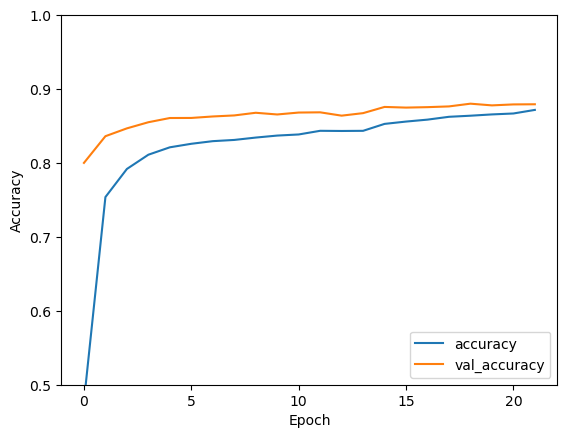

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

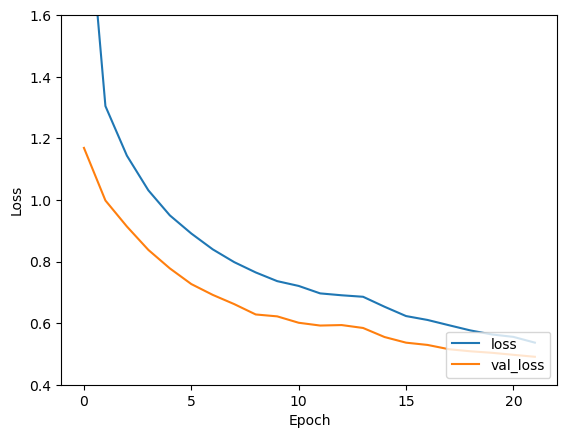

In [61]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.4, 1.6])
plt.legend(loc='lower right')

In [62]:
# Predict class indices
y_prob = fc_clf.predict(feat_valid, batch_size=1024, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# (optional) CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_valid_1d, y_pred))
print(classification_report(y_valid_1d, y_pred, digits=4, target_names=CLASS_NAMES))


Test accuracy (recomputed): 0.8802
              precision    recall  f1-score   support

    airplane     0.8847    0.8911    0.8879       973
  automobile     0.9376    0.9356    0.9366       979
        bird     0.9015    0.8262    0.8622      1030
         cat     0.7602    0.7840    0.7719      1023
        deer     0.8006    0.8821    0.8394       933
         dog     0.8410    0.8079    0.8241      1015
        frog     0.9300    0.9207    0.9253       996
       horse     0.9031    0.9004    0.9018       994
        ship     0.9308    0.9253    0.9280      1017
       truck     0.9212    0.9327    0.9269      1040

    accuracy                         0.8802     10000
   macro avg     0.8811    0.8806    0.8804     10000
weighted avg     0.8814    0.8802    0.8804     10000



In [63]:
# Predict class indices
y_prob = fc_clf.predict(feat_test, batch_size=1024, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# (optional) CIFAR-10 class names
CLASS_NAMES = ["airplane","automobile","bird","cat","deer",
               "dog","frog","horse","ship","truck"]

print("Test accuracy (recomputed):", accuracy_score(y_test_1d, y_pred))
print(classification_report(y_test_1d, y_pred, digits=4, target_names=CLASS_NAMES))

Test accuracy (recomputed): 0.8778
              precision    recall  f1-score   support

    airplane     0.8897    0.8950    0.8923      1000
  automobile     0.9345    0.9270    0.9307      1000
        bird     0.8827    0.8350    0.8582      1000
         cat     0.7551    0.7770    0.7659      1000
        deer     0.8284    0.8690    0.8482      1000
         dog     0.8391    0.8190    0.8289      1000
        frog     0.9099    0.9190    0.9144      1000
       horse     0.9074    0.8820    0.8945      1000
        ship     0.9253    0.9170    0.9211      1000
       truck     0.9116    0.9380    0.9246      1000

    accuracy                         0.8778     10000
   macro avg     0.8784    0.8778    0.8779     10000
weighted avg     0.8784    0.8778    0.8779     10000



# Results and interpretations